In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

## NEED TO SET UP meas_modelfit *before starting ipython* for code at bottom (not included in lsst_apps!)

In [2]:
import diffimTests as dit
reload(dit)

testObj = dit.DiffimTest(imSize=(256, 256),
                         varFlux2=np.repeat(5000, 10), 
                         #varFlux2=np.repeat(620*np.sqrt(2), 20),
                         n_sources=600/4, verbose=True, 
                         sourceFluxRange=(2000., 250000.), saturation=250000., 
                         #bad_columns=[255, 256, 257],
                         variablesAvoidBorder=3.5, psf_yvary_factor=0., psfSize=13)
res = testObj.runTest(spatialKernelOrder=2)
print res

Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0.0, 0.0]
Flux range: 246642.393478 2000.0
PSF y spatial-variation: 0.0 0.0
Variable source: 14 196.396399934 191.955509328 0 5000
Variable source: 0 206.917338547 114.54895376 0 5000
Variable source: 11 56.0101022569 161.464859606 0 5000
Variable source: 9 109.86163575 51.8176374461 0 5000
Variable source: 21 172.232208604 192.272549224 0 5000
Variable source: 15 85.9554656804 192.742268735 0 5000
Variable source: 24 82.2011229567 68.8410845187 0 5000
Variable source: 12 137.122266426 199.536441967 0 5000
Variable source: 26 180.413834482 119.971015294 0 5000
Variable source: 22 163.555013436 128.358309666 0 5000
0 saturated pixels (template)
0 saturated pixels (science)
{'Zogy': {'FP': 0, 'FN': 1, 'TP': 9}, 'ALstack': {'FP': 13, 'FN': 3, 'TP': 7}, 'SZogy': {'FP': 0, 'FN': 1, 'TP': 9}, 'ALstack_decorr': {'FP': 15, 'FN': 0, 'TP': 10}}


In [3]:
import lsst.pex.config as pexConfig
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.pipe.base as pipeBase
import lsst.ip.diffim as ipDiffim

In [4]:
exposure = testObj.im2.asAfwExposure()
template = testObj.im1.asAfwExposure()

In [5]:
exposure2 = testObj.im2.asAfwExposure()
obj = dit.tasks.PsfMeasurement(exposure2)
obj.run()
psf = obj.exposure.getPsf()
exposure2.setPsf(psf)

template2 = testObj.im1.asAfwExposure()
obj = dit.tasks.PsfMeasurement(template2)
obj.run()
psf = obj.exposure.getPsf()
template2.setPsf(psf)

131
123


In [6]:
def ga(exposure):
    return exposure.getMaskedImage().getImage().getArray()
def gv(exposure):
    return exposure.getMaskedImage().getVariance().getArray()
def gm(exposure):
    return exposure.getMaskedImage().getMask().getArray()

Test `computeDiffim`.

In [7]:
config = dit.ZogyConfig()
task = dit.ZogyTask(templateExposure=template, scienceExposure=exposure, config=config)

stats(mean=0.063107505, stdev=24.954721, min=-243.46489, max=267.38281)
stats(mean=603.11182, stdev=26.303705, min=503.75433, max=22096.289)


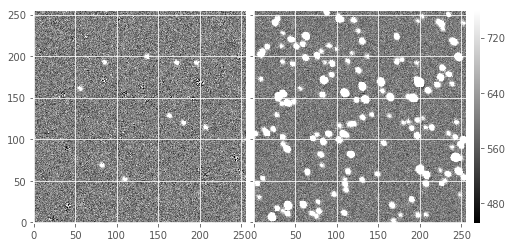

In [8]:
D = task.computeDiffim(inImageSpace=False)
print dit.computeClippedImageStats(ga(D))
print dit.computeClippedImageStats(gv(D))
dit.plotImageGrid((ga(D), gv(D)), imScale=4)

stats(mean=0.10233418, stdev=25.002806, min=-230.20177, max=267.38315)
stats(mean=604.33173, stdev=36.22966, min=476.5976, max=19910.977)


/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


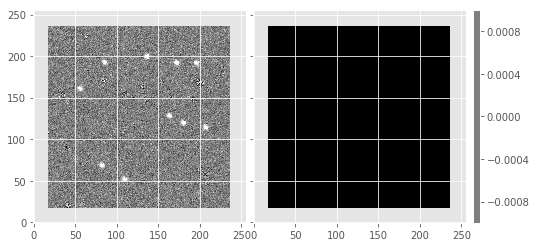

In [9]:
D = task.computeDiffim(inImageSpace=True)
print dit.computeClippedImageStats(ga(D))
print dit.computeClippedImageStats(gv(D))
dit.plotImageGrid((ga(D), gv(D)), imScale=4)

In [10]:
%timeit task.computeDiffim(inImageSpace=False)

10 loops, best of 3: 21.9 ms per loop


In [11]:
%timeit task.computeDiffim(inImageSpace=True)

1 loop, best of 3: 268 ms per loop


Test `computeScorr`.

stats(mean=-1.3849851e-07, stdev=0.00026396394, min=-0.0015362878, max=0.0079764649)
stats(mean=0.00025162601, stdev=1.2752243e-06, min=0.00024722287, max=0.001264248)


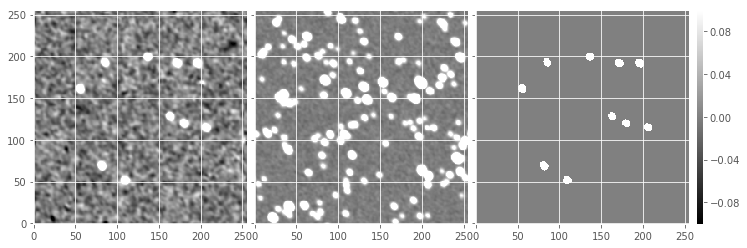

In [12]:
config = dit.ZogyConfig()
task = dit.ZogyTask(templateExposure=template, scienceExposure=exposure, config=config)

S = task.computeScorr(inImageSpace=False)
print dit.computeClippedImageStats(ga(S))
print dit.computeClippedImageStats(gv(S))
dit.plotImageGrid((ga(S), gv(S), (ga(S)/gv(S) > 5.0)), imScale=4)

stats(mean=-1.3849851e-07, stdev=0.00026396394, min=-0.0015362878, max=0.0079764649)
stats(mean=0.00025162601, stdev=1.2752243e-06, min=0.00024722287, max=0.001264248)
stats(mean=-1.3223062e-05, stdev=0.0065643792, min=-0.030844716, max=0.19617911)
stats(mean=0.0061885216, stdev=3.1375072e-05, min=0.0060803834, max=0.03109386)
stats(mean=0.03460269, stdev=0.033543672, min=-1170.4209, max=323.72296)
stats(mean=0.040659096, stdev=2.7378326e-09, min=0.040659085, max=0.0406591)


/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater


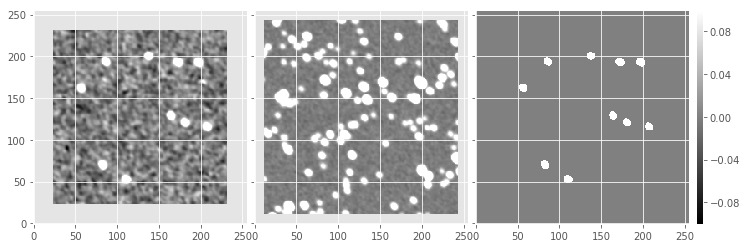

In [13]:
config = dit.ZogyConfig()
task = dit.ZogyTask(templateExposure=template, scienceExposure=exposure, config=config)

SR = task.computeScorr(inImageSpace=False)
S = task.computeScorr(inImageSpace=True)
print dit.computeClippedImageStats(ga(SR))
print dit.computeClippedImageStats(gv(SR))
print dit.computeClippedImageStats(ga(S))
print dit.computeClippedImageStats(gv(S))
print dit.computeClippedImageStats(ga(SR)/ga(S))
print dit.computeClippedImageStats(gv(SR)/gv(S))

dit.plotImageGrid((ga(S), gv(S), (ga(S)/gv(S) > 5.0)), imScale=4)

Test `computeScorr` with nonzero `x/yVarAst`

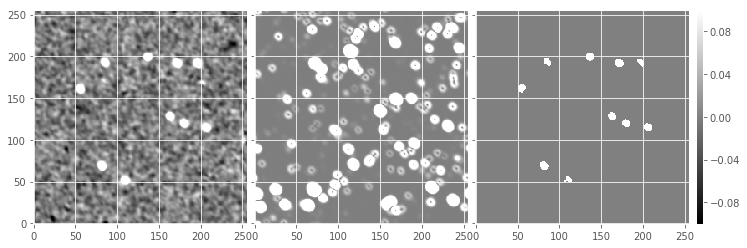

In [14]:
S = task.computeScorr(inImageSpace=False, xVarAst=0.1, yVarAst=0.1)
dit.plotImageGrid((ga(S), gv(S), (ga(S)/gv(S) > 5.0)), imScale=4)

/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


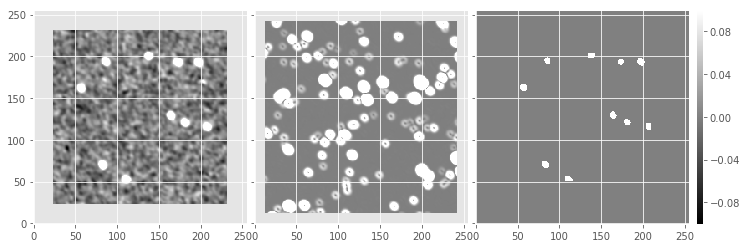

In [15]:
S = task.computeScorr(inImageSpace=True, xVarAst=0.1, yVarAst=0.1)
dit.plotImageGrid((ga(S), gv(S), (ga(S)/gv(S) > 5.0)), imScale=4)

Test imageMapper.

In [16]:
config = dit.zogyTask.ZogyMapReduceConfig()
config.gridStepX = config.gridStepY = 9
#config.gridSizeX = config.gridSizeY = 10
config.borderSizeX = config.borderSizeY = 3
config.reducerSubtask.reduceOperation = 'average'
task = dit.ImageMapReduceTask(config=config)
print config

{'gridStepY': 9.0, 'gridStepX': 9.0, 'mapperSubtask': {}, 'returnSubImages': False, 'gridSizeX': 10.0, 'gridSizeY': 10.0, 'gridCentroidsY': None, 'gridCentroidsX': None, 'reducerSubtask': {'reduceOperation': 'average'}, 'adjustGridOption': 'spacing', 'borderSizeX': 3.0, 'borderSizeY': 3.0, 'scaleByFwhm': True, 'ignoreMaskPlanes': ['INTRP', 'EDGE', 'DETECTED', 'SAT', 'CR', 'BAD', 'NO_DATA', 'DETECTED_NEGATIVE']}


Grid parameters: 47 47 34.2890625 34.2890625 14 14


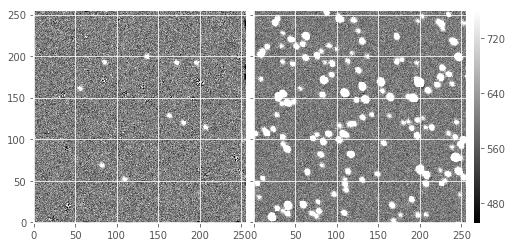

In [17]:
DF = task.run(exposure, template=template, inImageSpace=False,
             doScorr=False, forceEvenSized=True).exposure
dit.plotImageGrid((ga(DF), gv(DF)), imScale=4)

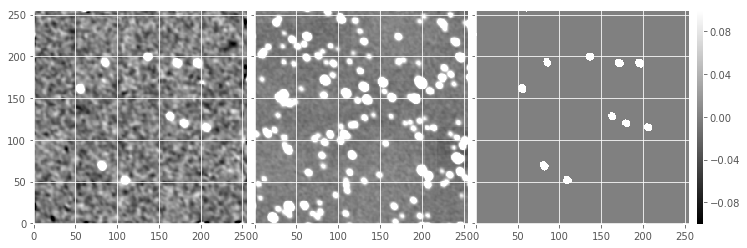

In [18]:
SF = task.run(exposure, template=template, inImageSpace=False,
              doScorr=True, forceEvenSized=True).exposure
dit.plotImageGrid((ga(SF), gv(SF), (ga(SF)/gv(SF) > 5.0)), imScale=4)

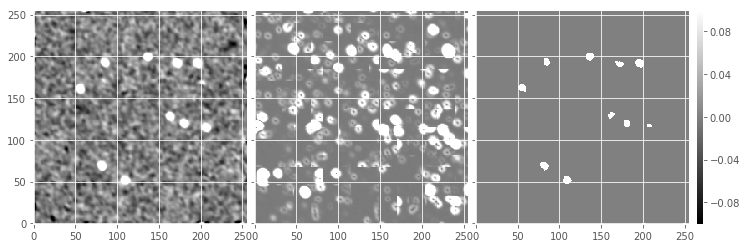

In [19]:
SF = task.run(exposure, template=template, inImageSpace=False,
              doScorr=True, forceEvenSized=True, xVarAst=0.1, yVarAst=0.1).exposure
dit.plotImageGrid((ga(SF), gv(SF), (ga(SF)/gv(SF) > 5.0)), imScale=4)

In [20]:
config = dit.zogyTask.ZogyMapReduceConfig()
config.gridStepX = config.gridStepY = 8
#config.gridSizeX = config.gridSizeY = 10
config.borderSizeX = config.borderSizeY = 6
config.reducerSubtask.reduceOperation = 'average'
task = dit.ImageMapReduceTask(config=config)
print config

{'gridStepY': 8.0, 'gridStepX': 8.0, 'mapperSubtask': {}, 'returnSubImages': False, 'gridSizeX': 10.0, 'gridSizeY': 10.0, 'gridCentroidsY': None, 'gridCentroidsX': None, 'reducerSubtask': {'reduceOperation': 'average'}, 'adjustGridOption': 'spacing', 'borderSizeX': 6.0, 'borderSizeY': 6.0, 'scaleByFwhm': True, 'ignoreMaskPlanes': ['INTRP', 'EDGE', 'DETECTED', 'SAT', 'CR', 'BAD', 'NO_DATA', 'DETECTED_NEGATIVE']}


Grid parameters: 47 47 30.20703125 30.20703125 28 28


diffimTests/imageMapReduce.py:283: RuntimeWarning: invalid value encountered in true_divide
  newMI.getImage().getArray()[:, :] /= wts
diffimTests/imageMapReduce.py:284: RuntimeWarning: invalid value encountered in true_divide
  newMI.getVariance().getArray()[:, :] /= wts


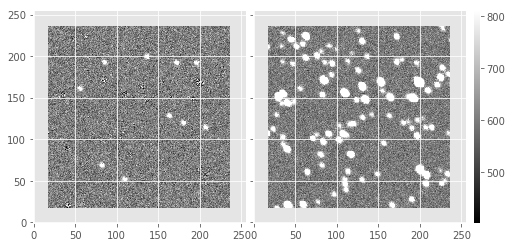

In [21]:
DR = task.run(exposure, template=template, inImageSpace=True,
              doScorr=False, forceEvenSized=True).exposure
dit.plotImageGrid((ga(DR), gv(DR)), imScale=4)

/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


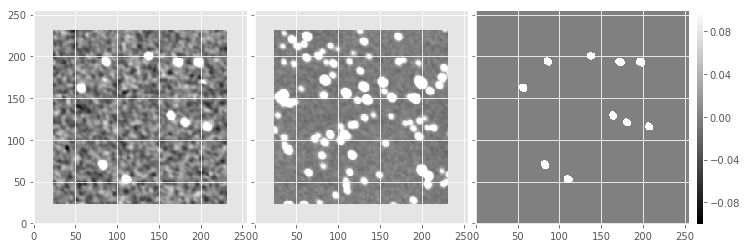

In [22]:
SR = task.run(exposure, template=template, inImageSpace=True,
                       doScorr=True, forceEvenSized=True).exposure
dit.plotImageGrid((ga(SR), gv(SR), (ga(SR)/gv(SR) > 5.0)), imScale=4)

In [23]:
print type(DR.getPsf()), type(SR.getPsf())

<class 'lsst.meas.algorithms.coaddPsf.CoaddPsf'> <class 'lsst.meas.algorithms.coaddPsf.CoaddPsf'>


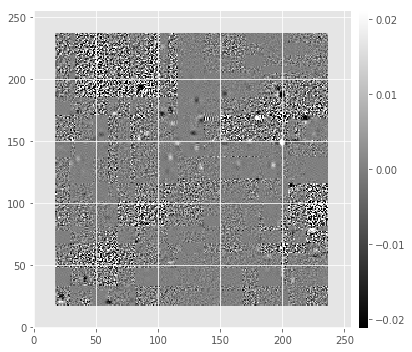

In [24]:
dit.plotImageGrid((ga(DF) - ga(DR),), imScale=6.)

Compare masks between image/fourier calculations.

In [25]:
config = dit.ZogyConfig()
task = dit.ZogyTask(templateExposure=template, scienceExposure=exposure, config=config)

D_F = task.computeDiffim(inImageSpace=False)
print dit.computeClippedImageStats(ga(D_F))
print dit.computeClippedImageStats(gv(D_F))

D_R = task.computeDiffim(inImageSpace=True)
print dit.computeClippedImageStats(ga(D_R))
print dit.computeClippedImageStats(gv(D_R))

stats(mean=0.063107505, stdev=24.954721, min=-243.46489, max=267.38281)
stats(mean=603.11182, stdev=26.303705, min=503.75433, max=22096.289)
stats(mean=0.10233418, stdev=25.002806, min=-230.20177, max=267.38315)
stats(mean=604.33173, stdev=36.22966, min=476.5976, max=19910.977)


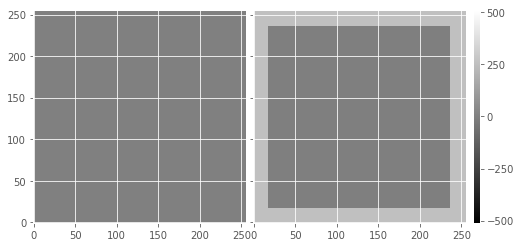

In [26]:
dit.plotImageGrid((gm(D_F), gm(D_R)), imScale=4)

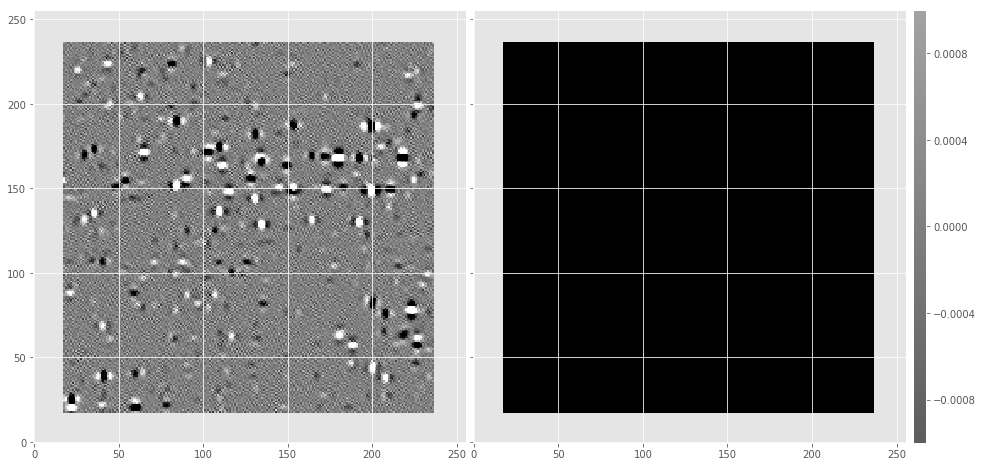

In [27]:
dit.plotImageGrid((ga(D_F) - ga(D_R), gv(D_F) - gv(D_R),), imScale=8)

stats(mean=0.063107505, stdev=24.954721, min=-243.46489, max=267.38281)
stats(mean=603.11182, stdev=26.303705, min=503.75433, max=22096.289)
stats(mean=0.10233418, stdev=25.002806, min=-230.20177, max=267.38315)
stats(mean=604.33173, stdev=36.22966, min=476.5976, max=19910.977)


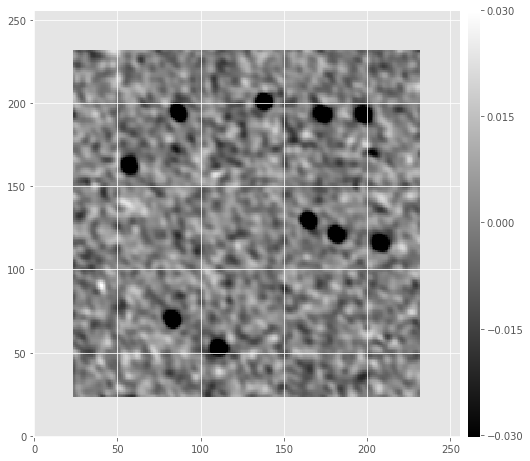

In [28]:
config = dit.ZogyConfig()
task = dit.ZogyTask(templateExposure=template, scienceExposure=exposure, config=config)

S_F = task.computeScorr(inImageSpace=False)
print dit.computeClippedImageStats(ga(D_F))
print dit.computeClippedImageStats(gv(D_F))

S_R = task.computeScorr(inImageSpace=True)
print dit.computeClippedImageStats(ga(D_R))
print dit.computeClippedImageStats(gv(D_R))

dit.plotImageGrid((ga(S_F) - ga(S_R),), imScale=8)

Debug the unit tests...

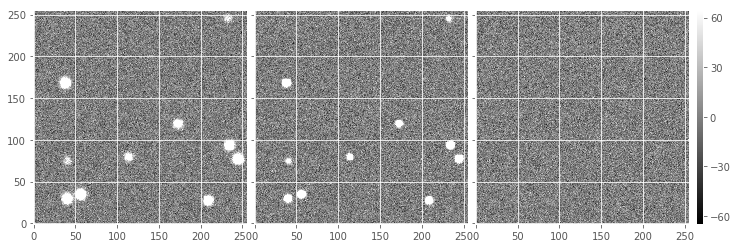

In [62]:
import testImageDecorrelation as testID

svar = tvar = 100.
psf1_sigma = 3.3  # sigma of psf of science image
psf2_sigma = 2.2  # sigma of psf of template image
varyPsf = False

im1ex, im2ex \
    = testID.makeFakeImages(svar=svar, tvar=tvar,
                            psf1=psf1_sigma, psf2=psf2_sigma,
                            n_sources=10, psf_yvary_factor=varyPsf,
                            seed=666, verbose=False)
# Create an array corresponding to the "expected" subtraction (noise only)
np.random.seed(666)
expectedSubtraction = np.random.normal(scale=np.sqrt(svar), size=im1ex.getDimensions())  # variance of science image
expectedSubtraction -= np.random.normal(scale=np.sqrt(tvar), size=im2ex.getDimensions())  # variance of template image
dit.plotImageGrid((ga(im1ex), ga(im2ex), expectedSubtraction), imScale=4)

stats(mean=-0.054275704347194184, stdev=13.859499534935104, min=-66.684194765577672, max=60.051378285527768)
stats(mean=-0.036631752159763858, stdev=13.972746182552516, min=-59.077525504849689, max=62.24877592299665)
stats(mean=-0.048816771858943932, stdev=13.888436836636496, min=-57.285279688127709, max=59.266842753983838)
stats(mean=0.02127026537594506, stdev=6.8636116609153381, min=-40.464102336105299, max=41.58395813152061)
stats(mean=-0.0098144978478702134, stdev=15.237804023020963, min=-62.062971336528626, max=64.876943403486749)
stats(mean=0.019981200681157558, stdev=16.102514504440144, min=-71.137025394196982, max=64.597354383433782)


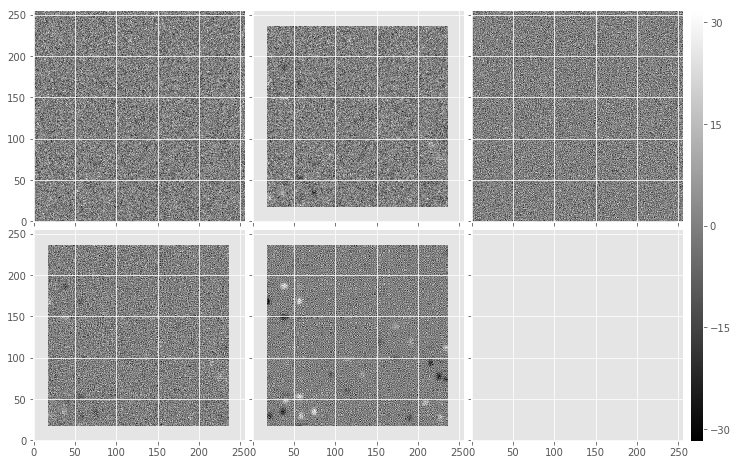

In [72]:
config = dit.ZogyConfig()
task = dit.ZogyTask(templateExposure=im2ex, scienceExposure=im1ex, config=config)

DF = task.computeDiffim(inImageSpace=False)
DR = task.computeDiffim(inImageSpace=True)
print dit.computeClippedImageStats(ga(DF))
print dit.computeClippedImageStats(ga(DR))
print dit.computeClippedImageStats(expectedSubtraction)
print dit.computeClippedImageStats(ga(DF)-ga(DR))
print dit.computeClippedImageStats(ga(DF)-expectedSubtraction)
print dit.computeClippedImageStats(ga(DR)-expectedSubtraction)
dit.plotImageGrid((ga(DF), ga(DR), 
                  ga(DF)-expectedSubtraction,
                  ga(DR)-expectedSubtraction,
                  ga(DF)-ga(DR)), imScale=4.)

0.0593449191327
0.326724077612


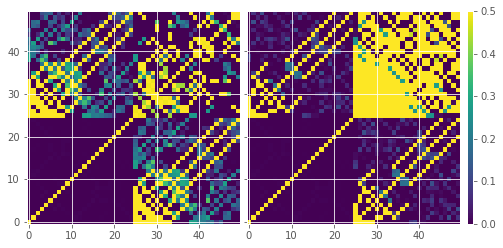

In [70]:
cov, stat = dit.utils.computePixelCovariance(ga(DF), expectedSubtraction)
print stat
cov2, stat = dit.utils.computePixelCovariance(ga(DF), ga(DR))
print stat
dit.plotImageGrid((cov, cov2), imScale=4., clim=(0, 0.5), cmap=None)

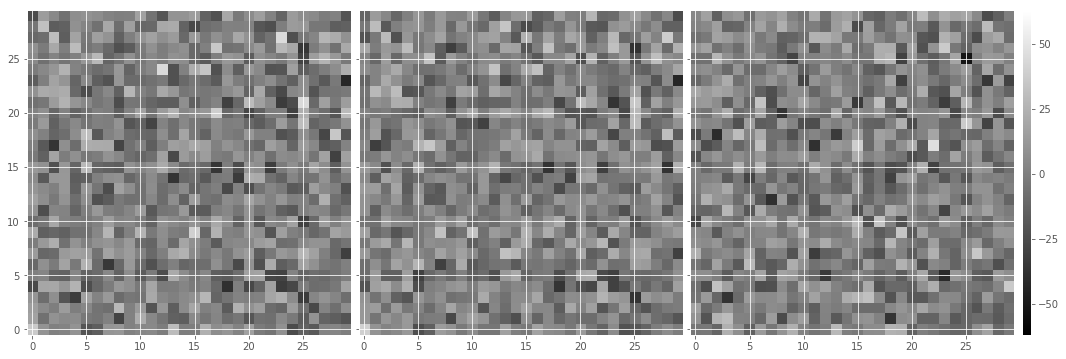

In [71]:
dit.plotImageGrid((ga(DF)[100:130,100:130], ga(DR)[100:130,100:130],
                   expectedSubtraction[100:130,100:130]), imScale=6.)